## Landscape Approximation

In [1]:
import numpy as np


def gaussian_benchmark(x, x0, S):
    """
    Calculate the Gaussian-based benchmark function as defined in the provided formula.

    Parameters:
    x (numpy array): Input vector.
    x0 (numpy array): Center vector.
    S (numpy array): Symmetric positive definite matrix.

    Returns:
    float: Value of the benchmark function.
    """
    diff = x - x0
    exponent = -np.dot(np.dot(diff.T, S), diff)
    return 1 - np.exp(exponent)


def c_shaped_plateau(x):
    """
    Calculate the C-shaped plateau function f_C(x) based on the given formula.

    Parameters:
    x (numpy array): Input vector.

    Returns:
    float: Value of the C-shaped plateau function.
    """
    # Define the matrix S as given in the text
    cov_matrices = [
        np.array([[1.0, 0.0], [0.0, 2.0]]),
        np.array([[2.0, 0.0], [0.0, 1.0]]),
        np.array([[1.0, 0.0], [0.0, 2.0]]),
    ]

    # Define the center vectors
    centers = [
        np.array([0.0, 1.5]),
        np.array([1.5, 0.0]),
        np.array([0.0, -1.5]),
    ]

    # Compute the product of all g functions
    result = 1.0
    for x0, cov in zip(centers, cov_matrices):
        result *= gaussian_benchmark(x, x0, cov)

    return result


In [2]:
from pyhms.core.problem import EvalCountingProblem, FunctionProblem
from pyhms import (
    EALevelConfig,
    DontStop,
    MetaepochLimit,
    SingularProblemEvalLimitReached,
    SEA,
    CMALevelConfig,
    TreeConfig,
    DemeTree,
)
from pyhms.sprout import get_NBC_sprout
from pyhms.demes.single_pop_eas.sea import SEA

N = 2
bounds = np.array([(-3, 3)] * N)

problem = FunctionProblem(c_shaped_plateau, maximize=False, bounds=bounds)
counting_problem = EvalCountingProblem(problem)
tree_config = [
    EALevelConfig(
        ea_class=SEA,
        generations=1,
        problem=counting_problem,
        pop_size=100,
        mutation_std=1.0,
        k_elites=5,
        election_group_size=30,
        lsc=DontStop(),
        p_mutation=0.8,
        p_crossover=0.3,
        mutation_std_step=0.1,
    ),
    CMALevelConfig(
        generations=20, problem=counting_problem, lsc=MetaepochLimit(10), sigma0=1.0
    ),
]

global_stop_condition = SingularProblemEvalLimitReached(10000)

sprout_condition = get_NBC_sprout()
config = TreeConfig(tree_config, global_stop_condition, sprout_condition)
hms_tree = DemeTree(config)
hms_tree.run()

In [3]:
from pyhms.cluster.landscape_approximator import LandscapeApproximator
from pyhms.cluster.merge_conditions import (
    HillValleyMergeCondition,
)
from pyhms.demes.single_pop_eas.sea import MWEA

problem = FunctionProblem(c_shaped_plateau, maximize=False, bounds=bounds)

mwea = MWEA.create(problem=problem, mutation_std=0.1, p_mutation=0.2)

la = LandscapeApproximator(
    hms_tree,
    HillValleyMergeCondition(
        FunctionProblem(c_shaped_plateau, maximize=False, bounds=bounds), 10
    ),
    10,
    mwea=mwea,
)
la.fit()
la.plot()

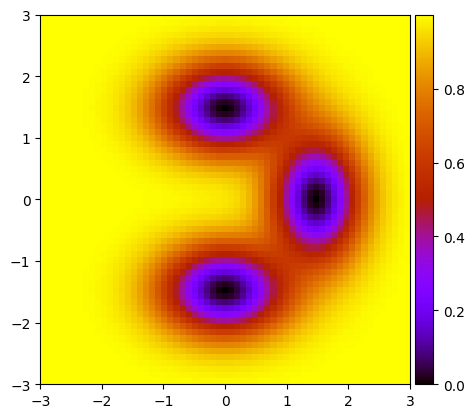

In [4]:
hms_tree.plot_problem_surface()

In [5]:
import plotly.express as px

reduced_clusters = la.cluster_reducer.reduce_clusters(la.clusters)
local_basin_population = la.local_basin_agent_executor(reduced_clusters)

px.scatter(
    x=local_basin_population.genomes[:, 0],
    y=local_basin_population.genomes[:, 1],
)